In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil
import math
from ParameterDistributions import *
from HaloParameters import *
import itertools

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)


## list of all parameters:
# R_es = [1.53239508, 2.90277581, 0.74401637, 1.18889862, 2.11042019, 0.98444861,
#  0.99960505, 1.42970509, 1.5681506,  0.88548025, 3.17477447, 0.82402456,
#  0.63540892, 1.05342352, 3.4766352,  1.47598624, 1.61196329, 1.42590726,
#  1.70731518, 1.39300399]

# GC_masses = [ 7.8762627,  17.79520947, 19.19769758,  5.75918816, 11.16904601, 16.12757648,
#   7.68512067,  5.51991984, 42.08897264, 22.00512255,  3.89387878, 12.21430189,
#   4.61469182, 25.89079167, 32.22007898, 18.81160987, 27.72601655, 10.28096513,
#   6.33986752, 38.22206118]

# halo_masses = [9.32726143*10**10, 2.62488939*10**10, 2.56044812*10**11, 6.88327683*10**10,
#  1.74653093*10**11, 1.03838141*10**11, 3.62040398*10**11, 7.14850956*10**10,
#  1.33619820*10**11, 4.68353599*10**10, 1.93382372*10**10, 1.67265950*10**11,
#  4.53786287*10**10, 3.68009259*10**10, 1.23862238*10**11, 7.34761068*10**10,
#  3.21975609*10**10, 3.27226465*10**11, 1.50636807*10**11, 7.54885922*10**9]


R_es = [2.64240876, 1.46217717, 2.46603934, 1.0543869, 1.59955803, 2.64850014, 
        2.35504928, 1.69044093, 1.19674053, 1.61064564, 1.03992017, 1.48593564, 
        0.83368118, 2.74157417, 2.65460556, 0.96161228, 0.9332543, 2.35504928, 3.62242998, 
        4.39541615, 3.90840896, 1.96336028, 2.01836636, 2.47742206, 0.7481695, 2.30674719, 
        1.74582215, 2.36047823, 2.17270118, 2.831392, 1.68655303, 1.16412603, 3.31894458, 
        0.98855309, 1.96336028, 3.08318795, 1.45881426, 1.76197605, 3.08318795, 1.24451461, 
        3.06902199, 2.57632116, 2.63633139, 2.96483139, 1.69044093, 0.7568329, 3.18419752, 
        1.5703628, 2.72270131, 1.78237877, 1.840772, 2.06062991, 1.59955803, 1.06659612,
        2.85101827, 0.58210322, 2.43220401, 3.25836701, 1.74582215, 2.61216135, 2.76057786,
        0.76032628, 2.59417936, 2.39331576, 4.07380278, 1.19124201, 2.21819642, 1.01624869, 
        1.59220873, 4.35511874, 2.76694165, 1.19124201, 2.1677041, 2.81838293, 2.96483139, 
        1.72981636, 1.3121999, 3.19889511, 3.52370871, 0.78704579, 2.80543364, 6.03948629, 
        2.25423921, 1.79060585, 2.78612117, 2.11348904, 2.39331576, 1.92309173, 2.70395836, 
        1.8238957, 1.14551294, 1.96336028, 1.90546072, 2.08929613, 1.2793813, 0.97274722, 
        1.4321879, 2.61216135, 2.13796209, 1.12719746]

GC_masses = [33.57376142, 21.82729912, 32.5836701, 8.16582371, 14.5881426, 5.21194711, 8.97428795, 
             14.85935642, 28.84031503, 3.66437575, 76.91304403, 7.58577575, 2.80543364, 14.09288798, 
             57.14786367, 11.58777356, 20.41737945, 69.3425806, 4.4874539, 9.79489985, 79.43282347, 
             11.14294534, 20.98939884, 43.55118737, 4.89778819, 8.97428795, 20.1372425, 31.18889584, 
             7.76247117, 28.84031503, 45.39416167, 15.31087462, 9.57194071, 22.80342072, 9.03649474, 
             15.63147643, 8.60993752, 15.41700453, 14.38798578, 6.60693448, 18.62087137, 70.63175543, 
             48.64072057, 24.77422058, 25.23480772, 11.83041556, 16.40589773, 13.77209469, 57.80960474, 
             1.57398286, 13.64583137, 34.59393778, 10.88930093, 26.12161354, 11.11731727, 42.65795188, 
             19.90673339, 9.09913273, 156.67510701, 28.31391996, 50.35006088, 5.48276965, 14.38798578, 
             10.39920166, 80.35261222, 12.73503081, 54.07543229, 11.29795915, 28.44461107, 8.01678063, 
             65.31305526, 2.17270118, 16.40589773, 12.58925412, 57.54399373, 21.57744409, 16.86553025, 
             13.18256739, 3.66437575, 12.16186001, 45.91980128, 19.95262315, 8.830799, 27.66941645, 
             20.37042078, 56.88529308, 13.27394458, 87.90225168, 10.64143018, 62.51726928, 48.64072057, 
             8.66961876, 74.64487584, 9.88553095, 9.44060876, 6.83911647, 44.25883724, 4.72063041, 
             26.79168325, 9.72747224]

halo_masses = [39810717100, 251188643000, 79432823500, 251188643000, 199526231000, 125892541000, 
               125892541000, 125892541000, 158489319000, 158489319000, 316227766000, 50118723400, 
               199526231000, 79432823500, 316227766000, 251188643000, 100000000000, 79432823500, 
               199526231000, 251188643000, 398107171000, 63095734400, 63095734400, 398107171000, 
               50118723400, 19952623100, 251188643000, 125892541000, 15848931900, 31622776600, 
               50118723400, 79432823500, 199526231000, 158489319000, 501187234000, 100000000000, 
               199526231000, 100000000000, 158489319000, 79432823500, 316227766000, 63095734400, 
               39810717100, 316227766000, 63095734400, 39810717100, 158489319000, 79432823500, 
               100000000000, 79432823500, 79432823500, 316227766000, 125892541000, 125892541000, 
               398107171000, 100000000000, 63095734400, 79432823500, 199526231000, 199526231000, 
               199526231000, 630957344000, 25118864300, 158489319000, 125892541000, 31622776600, 
               39810717100, 125892541000, 31622776600, 251188643000, 199526231000, 100000000000, 
               94328235000, 125892541000, 79432823500, 199526231000, 199526231000, 158489319000, 
               158489319000, 158489319000, 100000000000, 630957344000, 501187234000, 199526231000, 
               50118723400, 158489319000, 398107171000, 125892541000, 39810717100, 63095734400, 
               398107171000, 63095734400, 251188643000, 398107171000, 199526231000, 630957344000, 
               398107171000, 199526231000, 316227766000, 316227766000]


n = 3


In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
3.4998486042022705
3 2.13796209
finished until t = 0.0 0.5941593647003174
finished until t = 0.5 3.5847907066345215
finished until t = 1.0 9.311963319778442
finished until t = 1.5 17.744112730026245
finished until t = 2.0 28.92848300933838


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 2.5 42.85657453536987
finished until t = 3.0 59.69587779045105
finished until t = 3.5 79.51694178581238
finished until t = 4.0 102.37044906616211
finished until t = 4.5 128.30340194702148
finished until t = 5.0 157.36527299880981
finished until t = 5.5 189.47939038276672
finished until t = 6.0 224.66652512550354
finished until t = 6.5 262.8482298851013
finished until t = 7.0 304.12550377845764
finished until t = 7.5 348.2835659980774
finished until t = 8.0 395.4260883331299
finished until t = 8.5 445.4052994251251
finished until t = 9.0 498.36404061317444
finished until t = 9.5 554.2552905082703
finished until t = 10.0 613.0599737167358


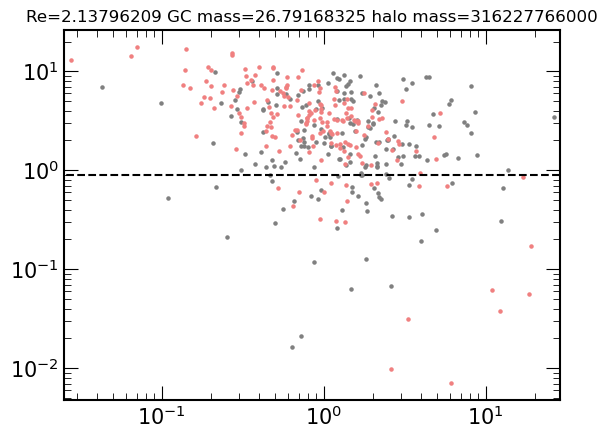

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
3.1235384941101074
3 1.12719746
finished until t = 0.0 0.18172764778137207
finished until t = 0.5 1.1767308712005615
finished until t = 1.0 2.9993577003479004
finished until t = 1.5 5.6947808265686035
finished until t = 2.0 9.256894826889038
finished until t = 2.5 13.661714792251587
finished until t = 3.0 18.997405529022217
finished until t = 3.5 25.13857889175415
finished until t = 4.0 32.19101357460022
finished until t = 4.5 40.11868596076965
finished until t = 5.0 48.88132619857788
finished until t = 5.5 58.48719620704651
finished until t = 6.0 68.97735023498535
finished until t = 6.5 80.26388096809387
finished until t = 7.0 92.38331151008606
finished until t = 7.5 105.25817775726318
finished until t = 8.0 118.92917990684509
finished until t = 8.5 133.3722162246704
finished until t = 9.0 148.669602394104
finished until t = 9.5 164.7108814716339
finished until t = 10.0 181.5959973335266


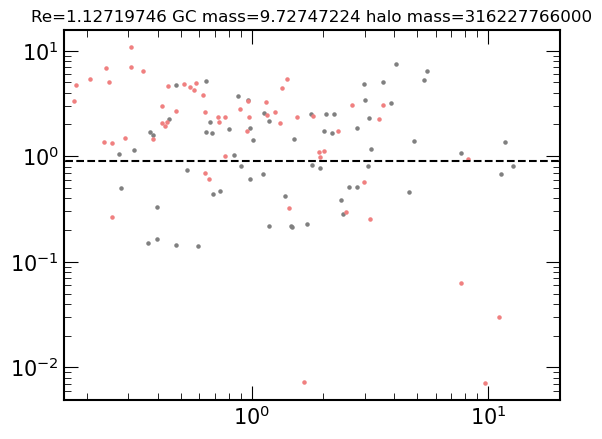

In [3]:
#NFW

#iterate over every combination of params
for i in range(20, len(R_es)):
    R_e = R_es[i]
    GC_mass = GC_masses[i]
    halo_mass = halo_masses[i]
    rho0 = rho_0_func(halo_mass)
    r0 = r_0_func(halo_mass)

    R_e_rounded = round(R_e, 3)
    GC_mass_rounded = round(GC_mass, 3)
    halo_mass_rounded = round(halo_mass, 1)
    rho0_rounded = round(rho0, 2)
    r0_rounded = round(r0, 2)

    file_name = 'Sim_'+'NFW_20'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt'
    file_path = '/home/vk9342/spring2024research/test_sim_run_M9/'+str(file_name)
    if not os.path.exists(file_path):
    
        ## a C implementation of friction and background forces in rebound, for speed
        clib_additional_forces = cdll.LoadLibrary("/home/vk9342/spring2024research/additional_forces_rho0"+str(rho0_rounded)+'_r0'+str(r0_rounded) +".so")
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho0 and r0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################
    
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho0, r0))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho0, r0, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]
    
        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho0 * r0**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)
    
        #making interpolated functions for f(E) that can be called in the initialization process for speed
    
        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
    
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr
        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)
    
            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
            # Sersic radial distribution and values to draw positions with their weights
    
            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)
    
    
            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)
    
            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < GC_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)
    
                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho0, r0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)
    
                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)
    
            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces_rho0"+str(rho0_rounded)+'_r0'+str(r0_rounded))
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23
    
            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []
    
            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            # integrating
            sim.integrate(t)
    
            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []
    
            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
            # clearing sim from memory now that we've stored everything important
            sim = None
    
            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
    
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs
    
        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
            start = time.time()
    
            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
    
                if output_time == 0:
                    # save initial data
                    f = open('/home/vk9342/spring2024research/test_sim_run_M9/Sim_'+output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('/home/vk9342/spring2024research/test_sim_run_M9/Sim_' +output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))
    
        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('/home/vk9342/spring2024research/test_sim_run_M9/Sim_'+'NFW_0'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('/home/vk9342/spring2024research/test_sim_run_M9/Sim_'+'NFW_20'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
    
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' GC mass='+str(GC_mass)+' halo mass='+str(halo_mass))
        # plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()


    # else:
    #     print('File already exists')


In [ ]:
def halo_mass_calc (M_star):
    alpha = 1.74
    M1 = 10**(12.5) #solar masses
    log_epsilon = -1.70
    M = M1 * 10**(1/alpha * (np.log10(M_star/M1) - log_epsilon))
    return M

M200 = halo_mass_calc(1.72 * 10**8)
print(M200/10**10)
h = 0.7
c = 5

M_star1 = 1.63 * 10**7
M_star2 = 1.72 * 10**8
M_star3 = 1.73 * 10**9


rho_crit = 0.00136 # critical density with h = 0.7 in units of 10^5/kpc^3
# NFW scale radius from M200 and c
r0_N = 1/c * (3*(M200/10**5)/(4*np.pi*200*rho_crit))**(1/3)
# NFW scale density from c
rho0_N = rho_crit * 200/3 * (c**3 / (np.log(1+c) - c/(1+c)))

print (r0_N, rho0_N)

In [ ]:
rho value (11.82) r0 19.54